In [1]:
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score, multilabel_confusion_matrix, f1_score, precision_score
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
import pickle
from sklearn.svm import SVC

In [2]:
class ChainSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, tol, reg, kernel, coef0, degree):
        super(ChainSVM, self).__init__()
        self.tol = tol
        self.reg = reg
        self.coef0 = coef0
        self.kernel = kernel
        self.degree = degree
        self.model = SVC(tol=self.tol, C = self.reg, class_weight='balanced', kernel = 'poly', coef0=self.coef0, degree = self.degree)
        self.chain = ClassifierChain(self.model, order="random", random_state=1)

    def fit(self, X_train, Y_train):
        #self.chain = ClassifierChain(self.model, order="random", random_state=1)
        return self.chain.fit(X_train, Y_train)
    
    def score(self, X_test, Y_test):
        Y_pred_chain = self.chain.predict(X_test)
        precision = precision_score(Y_test, Y_pred_chain>=0.5, average='samples')
        return precision 
        

In [3]:
x = np.load('../Part1.npy')
Y_t = np.load('../train.npy/y_train.npy')
#X_train = (x-np.min(x))/(np.max(x)-np.min(x))
xt = np.load('../Part2.npy')
Y_te = np.load('../test.npy/Y_Test.npy')
#X_test = (xt-np.min(xt))/(np.max(xt)-np.min(xt))
x_add = np.load('../Part3.npy')
y_add = np.load('../additional.npy/Y_additional.npy')
#x_add = (x_add-np.min(x_add))/(np.max(x_add)-np.min(x_add))
Y = np.concatenate((Y_t, Y_te, y_add))
X = np.concatenate((x, xt, x_add))
#X_train = (X_train-np.min(X_train))/(np.max(X_train)-np.min(X_train))
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [4]:
search_space = {
    'coef0':(0.0,1),
    'degree':(2,8)
}

test = ChainSVM(0.0001, 1, 'rbf', coef0=0.0, degree = 3)
opt = BayesSearchCV(test, search_space, n_iter=50, cv=7, n_jobs=-1)
opt.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

BayesSearchCV(cv=7,
              estimator=ChainSVM(coef0=0.0, degree=3, kernel='rbf', reg=1,
                                 tol=0.0001),
              n_jobs=-1, search_spaces={'coef0': (0.0, 1), 'degree': (2, 8)})

In [5]:
print("Best parameters found: ", opt.best_params_)
print("Best score: ", opt.best_score_)

Best parameters found:  OrderedDict([('coef0', 0.036395032474115914), ('degree', 4)])
Best score:  0.4004453898823373


In [6]:
import warnings
warnings.filterwarnings("ignore")
svm = SVC(C=0.15, tol=0.041, kernel='poly', coef0=0.79, degree=6)
chains = [ClassifierChain(svm, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_max = Y_pred_chains.max(axis=0)

In [7]:
Y_pred_ensemble = Y_pred_chains.mean(axis=0)
Y_pred = np.where(Y_pred_ensemble>0.5,1,0)
m = multilabel_confusion_matrix(Y_test, Y_pred)
print(m)

[[[688   9]
  [ 15   7]]

 [[702   5]
  [ 11   1]]

 [[681   5]
  [ 31   2]]

 [[550  35]
  [ 96  38]]

 [[453  44]
  [131  91]]

 [[615  13]
  [ 74  17]]

 [[371  88]
  [ 87 173]]

 [[617   9]
  [ 73  20]]

 [[666   6]
  [ 42   5]]

 [[656   9]
  [ 40  14]]

 [[406  62]
  [146 105]]]


In [8]:
tp = sum(m[:,1,1])
fp = sum(m[:,0,1])
tn = sum(m[:,0,0])
fn = sum(m[:,1,0])
print(tp, fp, tn, fn)

473 285 6405 746


In [9]:
precision = np.array([x[1,1]/(x[1,1]+x[0,1]) for x in m])
recall = np.array([x[1,1]/(x[1,1]+x[1,0]) for x in m])
f1 = 2*precision*recall/(precision+recall)
print(precision)

[0.4375     0.16666667 0.28571429 0.52054795 0.67407407 0.56666667
 0.66283525 0.68965517 0.45454545 0.60869565 0.62874251]


In [10]:
recall

array([0.31818182, 0.08333333, 0.06060606, 0.28358209, 0.40990991,
       0.18681319, 0.66538462, 0.21505376, 0.10638298, 0.25925926,
       0.41832669])

In [11]:
f1

array([0.36842105, 0.11111111, 0.1       , 0.36714976, 0.50980392,
       0.28099174, 0.66410749, 0.32786885, 0.17241379, 0.36363636,
       0.50239234])

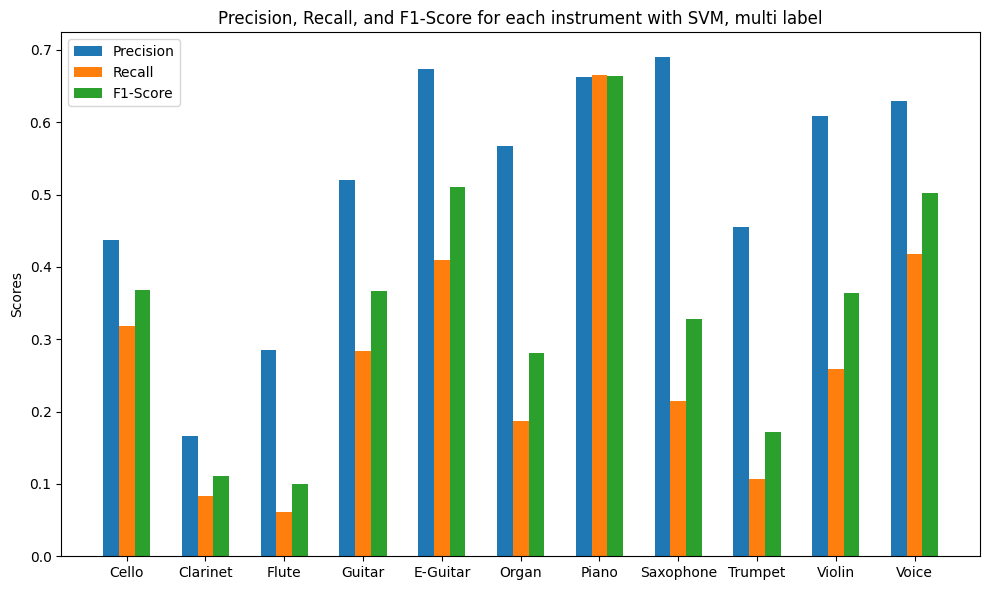

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
x_ax = ["Cello","Clarinet", "Flute", "Guitar", "E-Guitar", "Organ", "Piano", "Saxophone", "Trumpet", "Violin", "Voice"]
x = np.arange(len(precision))  # the label locations
width = 0.2  # the width of the bars
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-Score')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for each instrument with SVM, multi chain')
ax.set_xticks(x)
ax.set_xticklabels([i for i in x_ax])
ax.legend()
fig.tight_layout()
plt.savefig('ScoresSVMmulti.png')
plt.show()

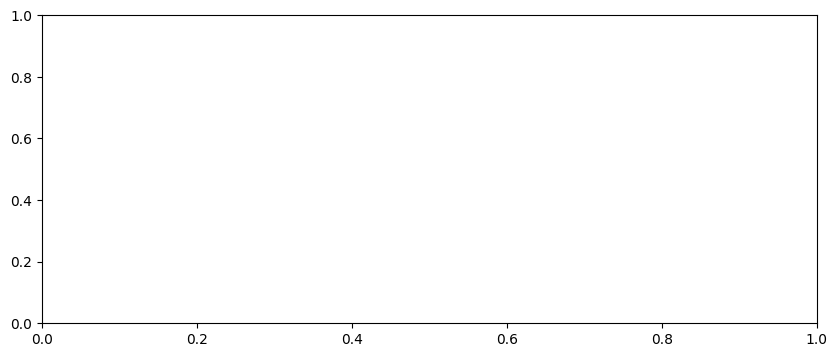

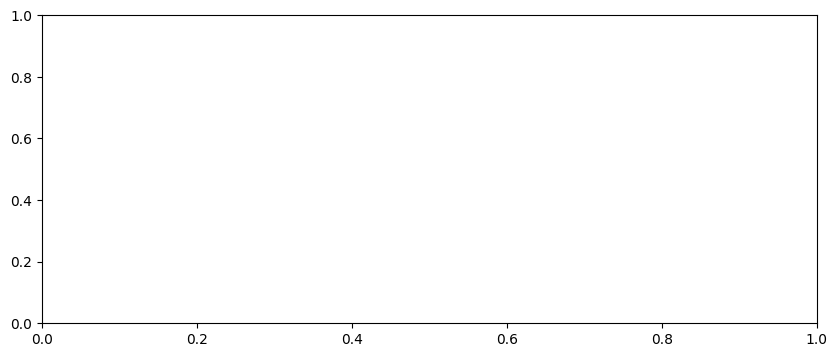

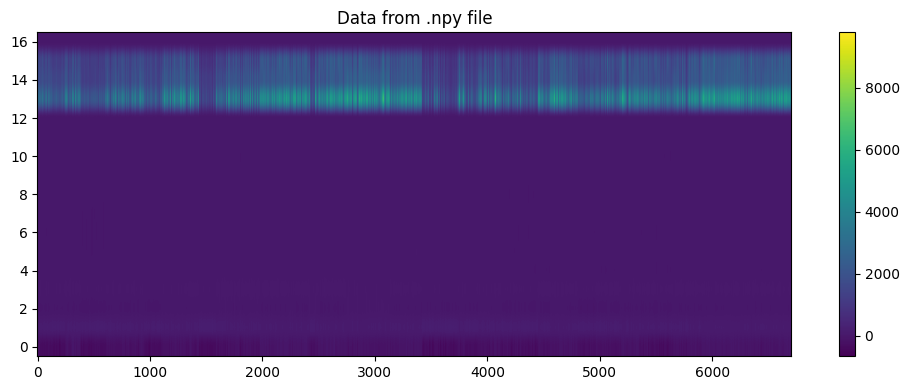

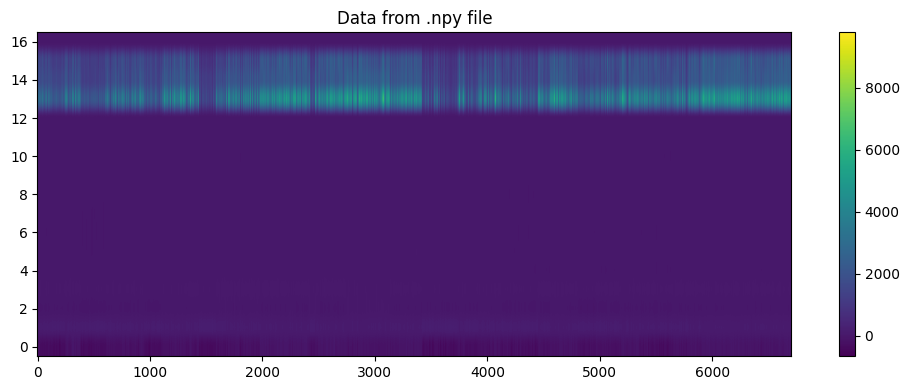

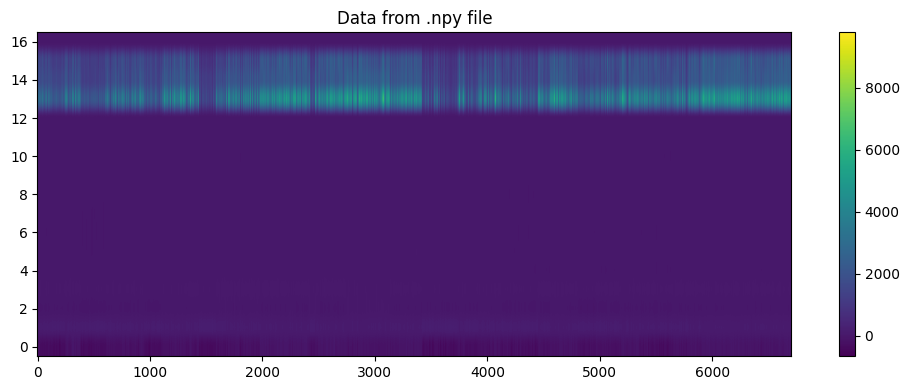

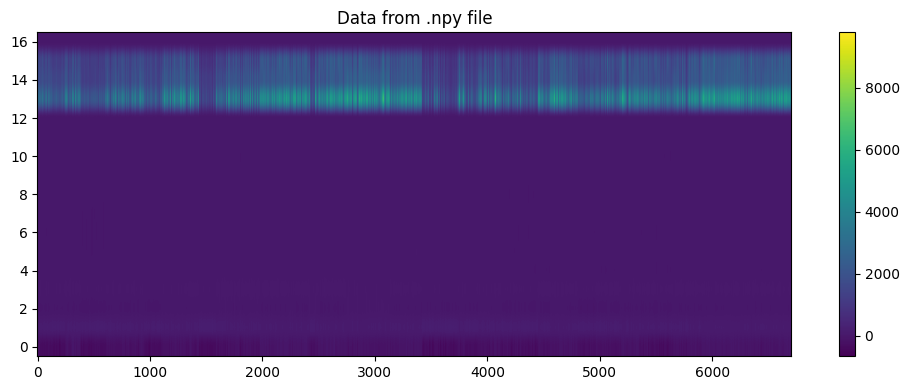

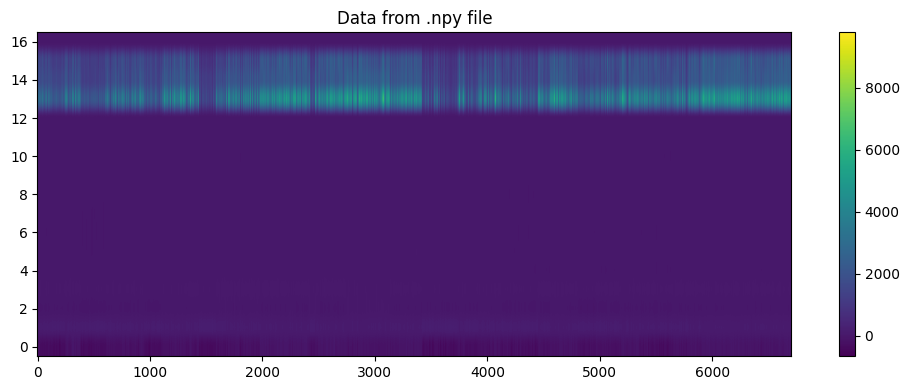

AttributeError: module 'matplotlib' has no attribute 'pyplot'

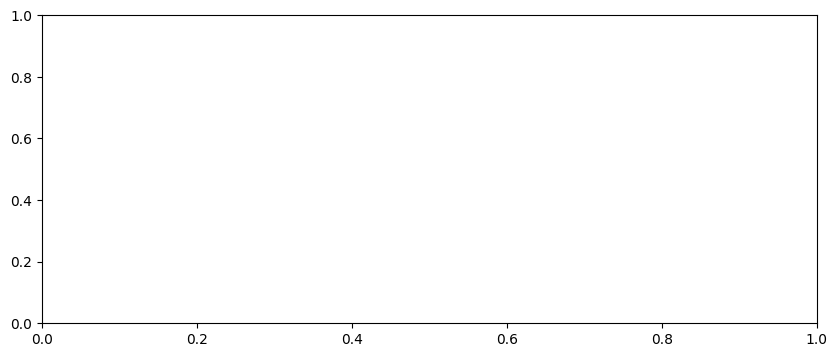

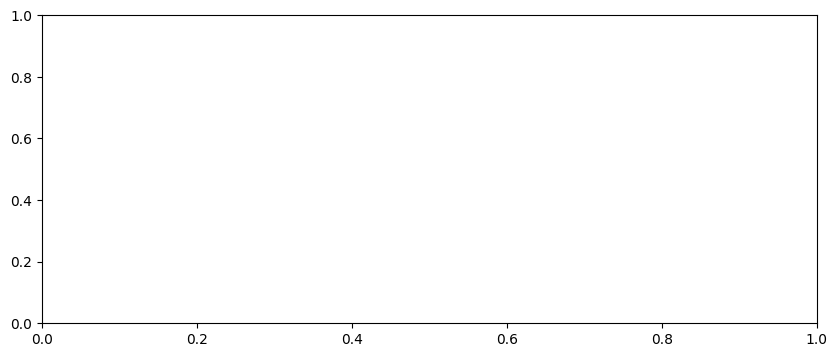

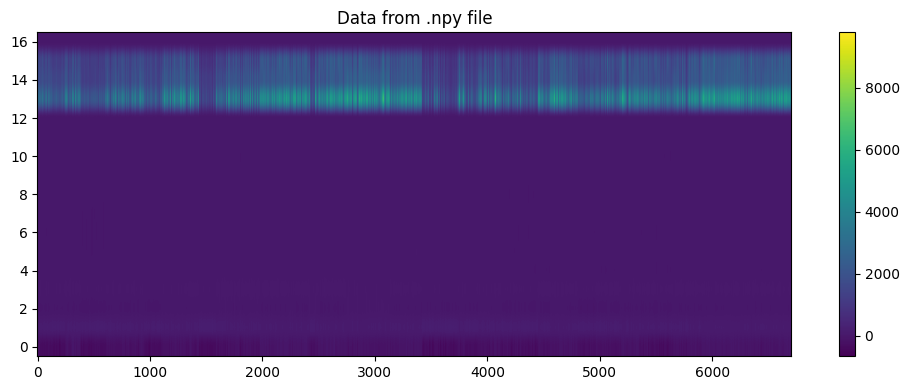

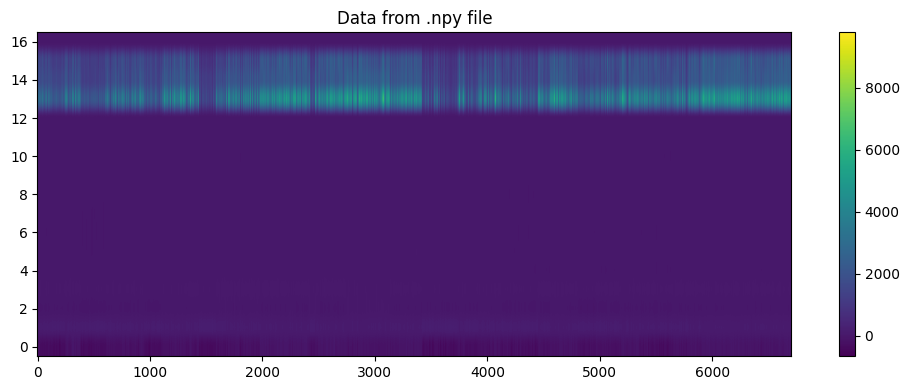

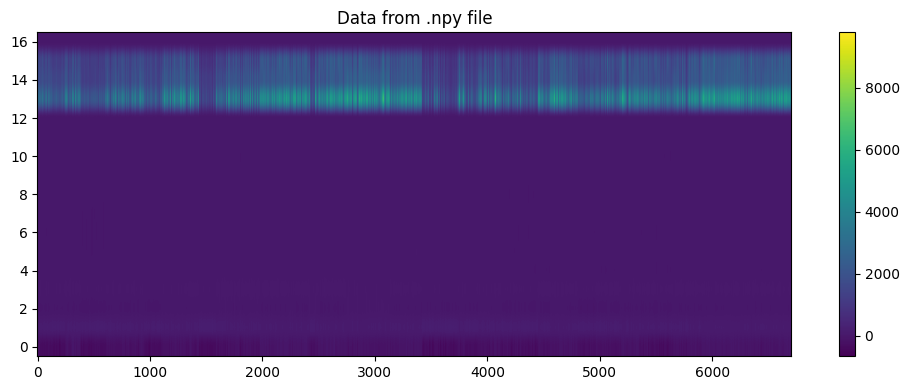

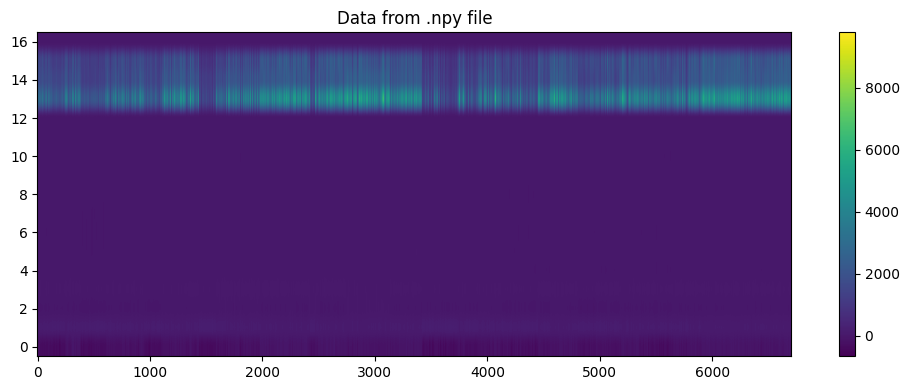

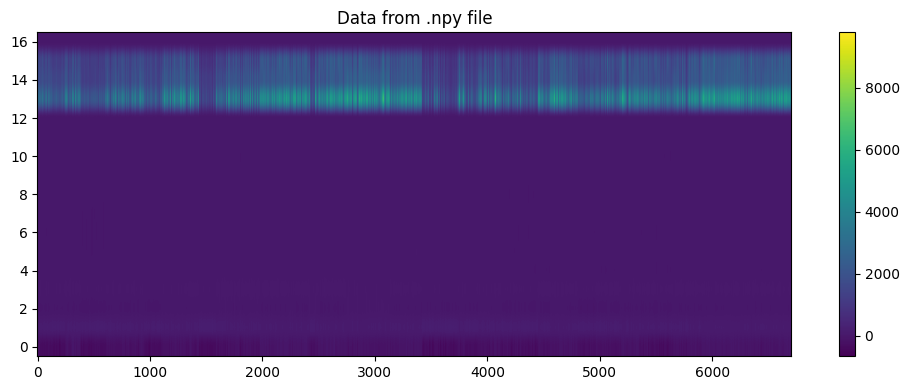

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [15]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Laden der Daten aus der .npy-Datei
data = np.load('X_single.npy')

# Plotten der Daten
plt.figure(figsize=(10, 4))
plt.imshow(data.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Data from .npy file')
plt.tight_layout()
plt.show()



In [10]:
y = np.load('X_single.npy')
print(y)

[[-5.01399261e+02  1.42089584e+02 -2.48803253e+01 ...  1.47527468e+03
   1.18484870e+03  6.62973257e-02]
 [-4.46797882e+02  1.26650749e+02 -2.61299362e+01 ...  1.57641336e+03
   1.29652350e+03  6.89227764e-02]
 [-4.00837189e+02  1.15451767e+02 -3.15040569e+01 ...  1.62721712e+03
   1.44166498e+03  8.16894531e-02]
 ...
 [-9.34939575e+01  8.04945297e+01  7.02774644e-01 ...  2.62207905e+03
   2.65587798e+03  1.24147386e-01]
 [-8.59429016e+01  6.20394402e+01 -9.49224758e+00 ...  2.61194464e+03
   3.00253838e+03  1.69362230e-01]
 [-5.76712227e+01  8.36771927e+01 -2.30610237e+01 ...  2.33855928e+03
   2.38729883e+03  1.21536959e-01]]
